In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
batch_size=32

In [4]:
import random
random.seed(42)

In [5]:
def import_ff_data(filename):
    expected_columns=155
    data = []
    with open(filename, 'r') as file:
        for line in file:
            row = line.strip().split(',')
            if len(row) < expected_columns:
                row += [np.nan] * (expected_columns - len(row))
            data.append(row)
    df = pd.DataFrame(data)
    def fill_last_valid(row):
        for i in range(1, len(row)):
            if pd.isna(row[i]):
                row[i] = row[i - 1]  
        return row
    df_filled = df.apply(fill_last_valid, axis=1)
    return df_filled

In [6]:
ff_burned = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_burned.csv")

In [7]:
data_output = ff_burned
data_output_helper = data_output
new_row = [10000] * data_output_helper.shape[1]
data_output_helper.loc[len(data_output_helper)] = new_row
scaler = MinMaxScaler()
scaler.fit(data_output_helper)
data_output_scaled = scaler.transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=20000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# Save validation data for baseline

valid_data.iloc[:, :1].to_csv("valid_inputs_ff.csv", index=False)
valid_data.iloc[:, 1:].to_csv("valid_outputs_ff.csv", index=False)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :1].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data_pd.iloc[:, 1:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :1].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 1:].values, dtype=torch.float32)

In [8]:
data

,0,0,1,2,3,4,5,6,7,8,...,145,146,147,148,149,150,151,152,153,154
3915,0.807362,0.0,0.0221,0.0563,0.0902,0.1247,0.1544,0.1832,0.2090,0.2443,...,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041,0.8041
28069,0.269829,0.0,0.0035,0.0045,0.0057,0.0058,0.0058,0.0058,0.0058,0.0058,...,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058,0.0058
80496,0.004474,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
51846,0.574144,0.0,0.0120,0.0281,0.0425,0.0565,0.0721,0.0901,0.1063,0.1219,...,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767,0.5767
55195,0.523205,0.0,0.0103,0.0237,0.0336,0.0434,0.0550,0.0654,0.0777,0.0940,...,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160,0.5160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28247,0.171343,0.0,0.0030,0.0046,0.0050,0.0051,0.0051,0.0051,0.0051,0.0051,...,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051,0.0051
25808,0.664943,0.0,0.0187,0.0368,0.0576,0.0780,0.1034,0.1276,0.1480,0.1678,...,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649,0.6649
3529,0.974031,0.0,0.0321,0.0791,0.1259,0.1820,0.2303,0.2729,0.3223,0.3721,...,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728,0.9728
35199,0.543252,0.0,0.0127,0.0241,0.0355,0.0478,0.0588,0.0724,0.0835,0.0992,...,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343,0.5343


In [9]:
train_inputs.shape[0]

16000

In [10]:
torch.manual_seed(1)

In [11]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([16000, 156])

In [12]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [13]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [14]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=155, condition_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [15]:
discriminator = ConditionalDiscriminator()

In [16]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1, output_dim=155):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.temporal_smoother = nn.Conv1d(1, 1, kernel_size=5, padding=2)  # keeps shape

    def forward(self, z, conditions):
        x = torch.cat([z, conditions], dim=1)
        out = self.fc(x)
        out = out.unsqueeze(1)  # (B, 1, 252)
        out = self.temporal_smoother(out)
        return out.squeeze(1)

generator = ConditionalGenerator()

In [17]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [18]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [19]:
losses_discriminator = []
losses_generator = []
steps = []

for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0 and epoch % 25 == 0:  # Adjust this number to control how often you log
            losses_discriminator.append(loss_discriminator.item())
            losses_generator.append(loss_generator.item())
            steps.append(epoch * len(train_loader) + n)
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.6900402307510376
Epoch: 0 Step: 0 Loss G.: 0.7706272006034851
Epoch: 0 Step: 100 Loss D.: 0.8165402412414551
Epoch: 0 Step: 100 Loss G.: 1.5510315895080566
Epoch: 0 Step: 200 Loss D.: 0.2113112509250641
Epoch: 0 Step: 200 Loss G.: 3.513951301574707
Epoch: 0 Step: 300 Loss D.: 0.01784582808613777
Epoch: 0 Step: 300 Loss G.: 4.340051174163818
Epoch: 0 Step: 400 Loss D.: 0.9282177686691284
Epoch: 0 Step: 400 Loss G.: 2.317354917526245
Epoch: 25 Step: 0 Loss D.: 0.16209864616394043
Epoch: 25 Step: 0 Loss G.: 2.2145750522613525
Epoch: 25 Step: 100 Loss D.: 0.560196578502655
Epoch: 25 Step: 100 Loss G.: 2.527963638305664
Epoch: 25 Step: 200 Loss D.: 0.4618317484855652
Epoch: 25 Step: 200 Loss G.: 2.303621768951416
Epoch: 25 Step: 300 Loss D.: 0.5571266412734985
Epoch: 25 Step: 300 Loss G.: 1.359405517578125
Epoch: 25 Step: 400 Loss D.: 0.7107207775115967
Epoch: 25 Step: 400 Loss G.: 2.5484964847564697
Epoch: 50 Step: 0 Loss D.: 0.4072403907775879
Epoch: 50 Step: 0

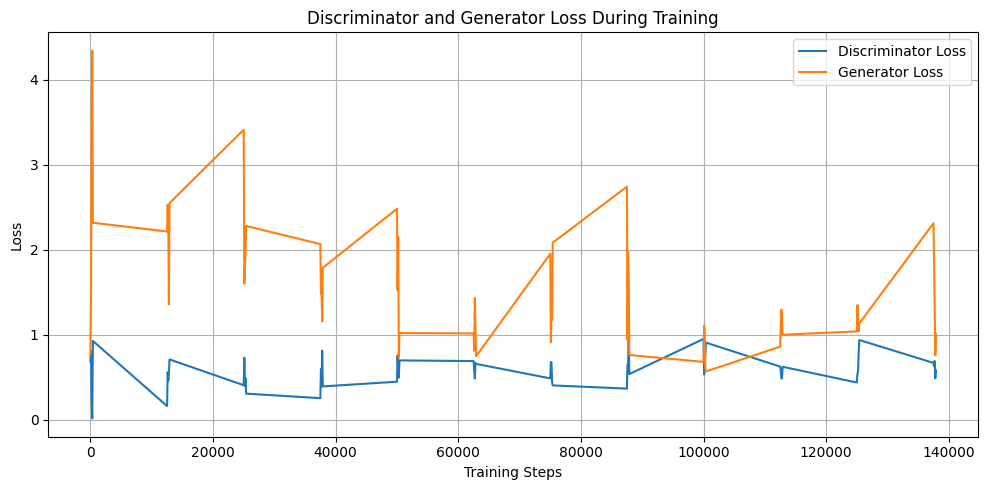

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses_discriminator, label='Discriminator Loss')
plt.plot(steps, losses_generator, label='Generator Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss During Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
torch.save(generator.state_dict(), "generator_gan_ff_ts_128.pth")
torch.save(discriminator.state_dict(), "discriminator_gan_ff_ts_128.pth")

In [22]:
import random

# Pick N random examples from your validation set
n_samples = 4000
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [23]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

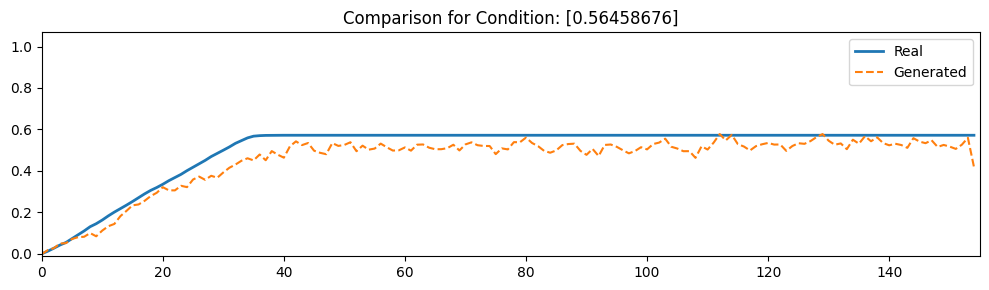

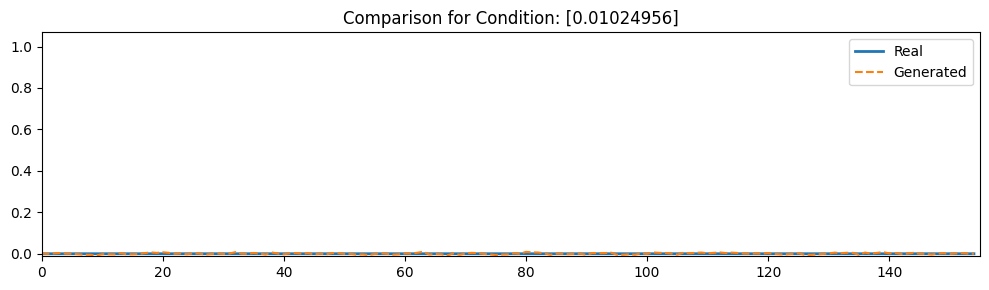

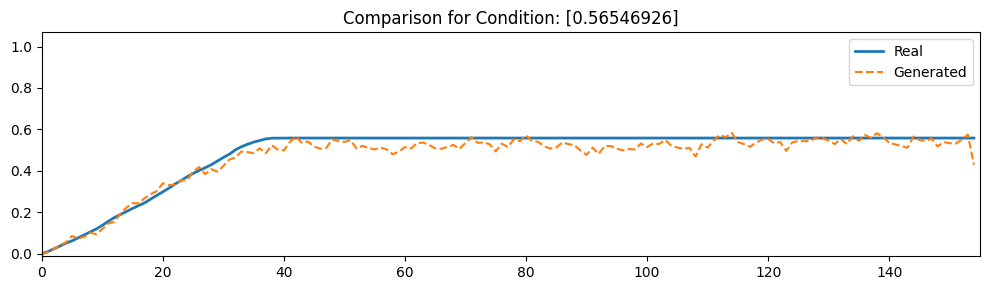

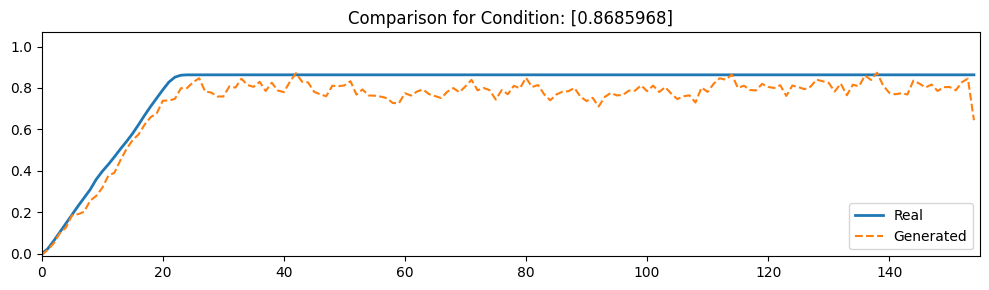

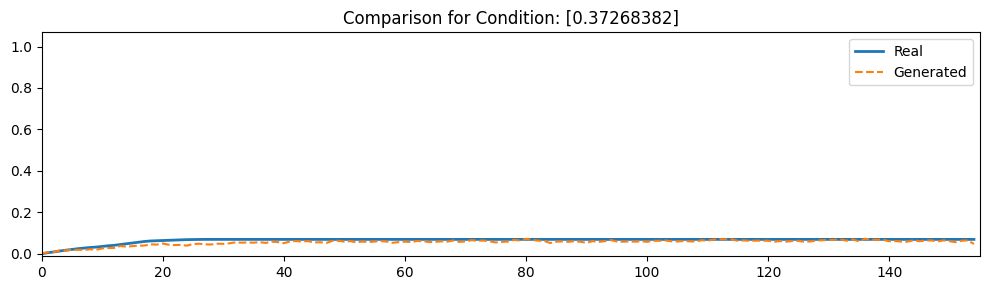

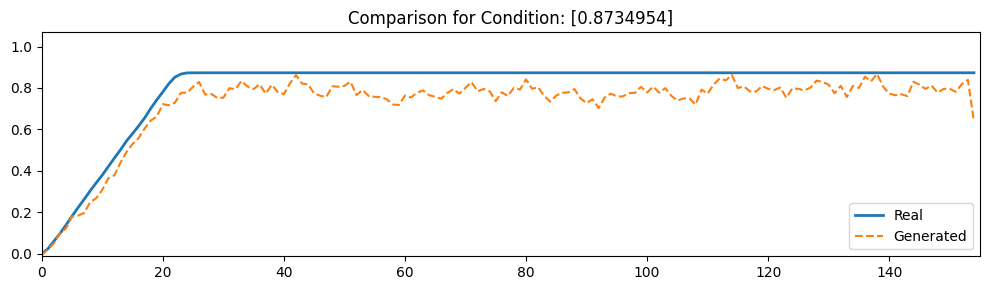

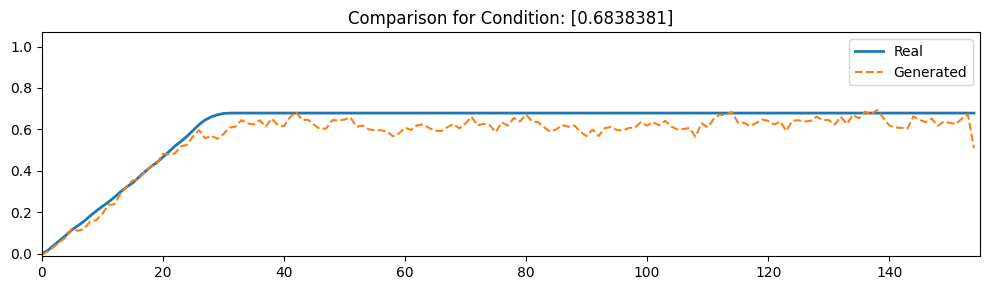

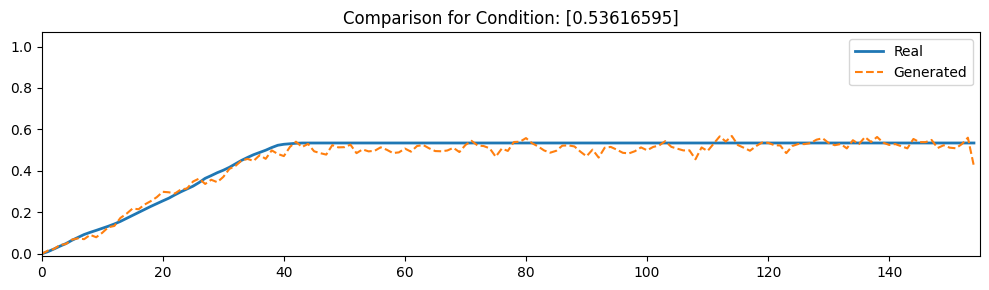

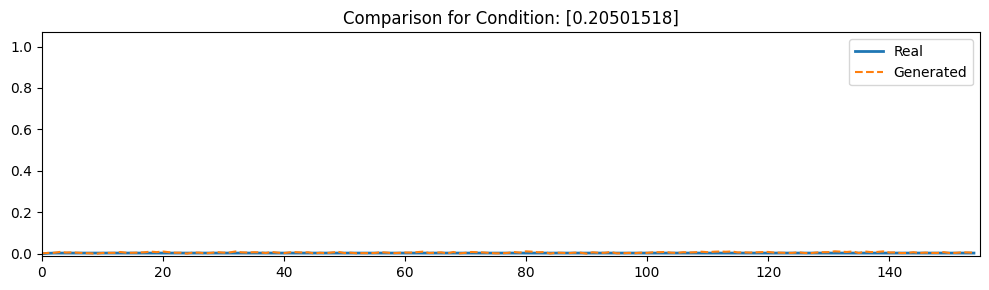

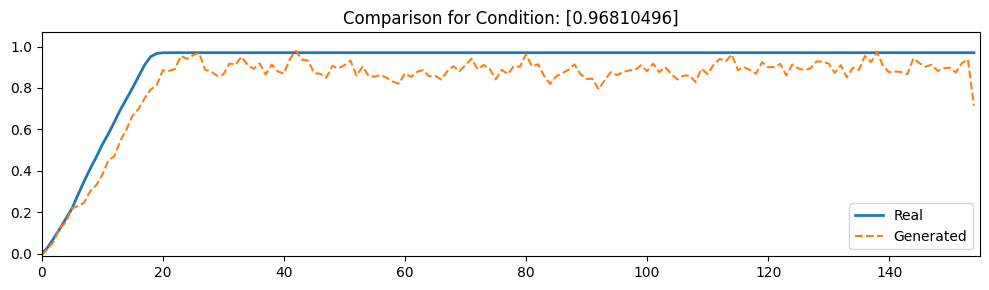

In [24]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(10):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
def evaluate_model_gan(real_samples, generated_samples):

    # convert list to numpy arrays
    predicted_values = generated_samples.cpu().numpy()  # [N, 255, 1]
    true_values = real_samples.cpu().numpy()            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.005462
Validation MAE: 0.047313
Validation R² Score: 0.958086


(0.005462230648845434, 0.0473128966987133, 0.9580861926078796)